In [33]:
import pytesseract
import numpy as np
import re
import csv
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Paragraph
import torch
import doctr
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import tempfile
import os
import langdetect
from langdetect.lang_detect_exception import LangDetectException

# Image processing 

In [37]:
# Load the image
image_path = "Fine.jpeg"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error: Unable to load the image.")
else:
    print("Image loaded successfully.")

Image loaded successfully.


### Document detection and cropping 


0: 800x576 1 paper-document-, 20.9ms
Speed: 5.0ms preprocess, 20.9ms inference, 2.0ms postprocess per image at shape (1, 3, 800, 576)


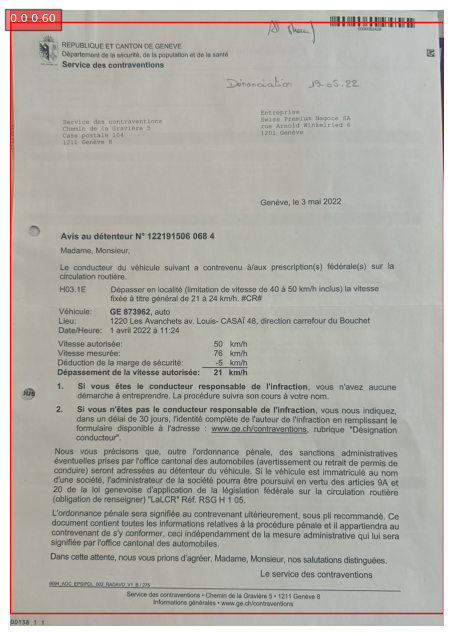

In [38]:
from ultralytics import YOLO
import torch  # Import torch to call .cpu() on tensors
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load your model
model = YOLO('D:/downloads/NewAndEnhancedWork2/runs/detect/train8/weights/best.pt')

# Run prediction
results = model(image)

# Assuming that the first item in results contains the detections
detections = results[0].boxes

# Load your image
img = Image.open(image_path)
plt.figure(figsize=(12, 8))
plt.imshow(img)

for det in detections:
    # Access the attributes of each detection
    # Ensure that the tensor is moved to CPU before converting to numpy
    xmin, ymin, xmax, ymax = det.xyxy[0].cpu().numpy()
    conf = det.conf.item()  # Convert to standard Python number using .item()
    cls = det.cls.item()  # Convert to standard Python number using .item()

    # Create a rectangle patch and add it to the plot
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor="r", facecolor="none", label=f"Class ID: {cls}")
    plt.gca().add_patch(rect)
    # Use standard Python formatting syntax
    plt.text(xmin, ymin, f"{cls} {conf:.2f}", color="white", fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
# Hide axis
plt.axis('off')

# Save the resulting plot with the bounding boxes to a file
#output_path = 'Fine8_annotated.jpeg'
#plt.savefig(output_path)

# Show the plot with bounding boxes
plt.show()

#print(f"Annotated image saved as: {output_path}")


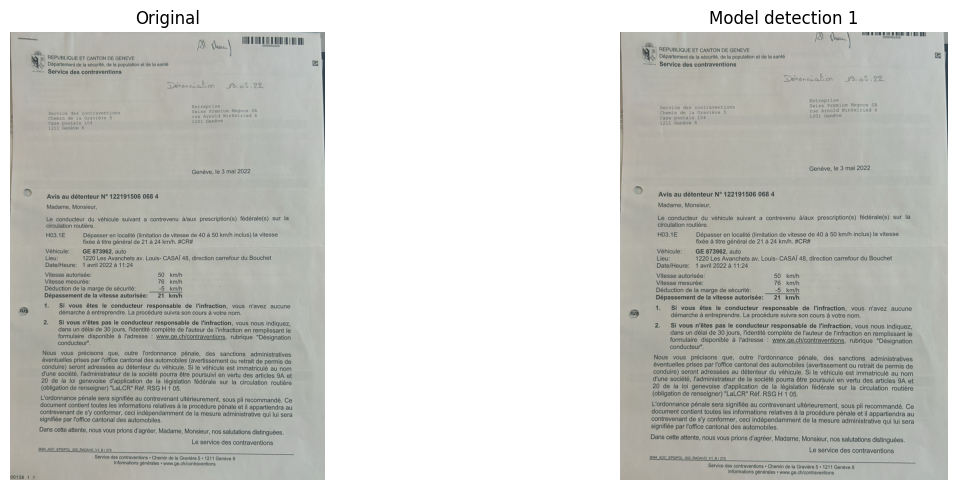

In [39]:
# Create a subplot grid for displaying the original image and cropped images
plt.figure(figsize=(15, 5))

# Display the original image
plt.subplot(1, len(detections) + 1, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Iterate through each detection
for det_index, det in enumerate(detections):
    # Access the attributes of each detection
    xmin, ymin, xmax, ymax = det.xyxy[0].cpu().numpy()
    
    # Crop the image based on bounding box coordinates
    cropped_img = img.crop((xmin, ymin, xmax, ymax))
    
    # Display the cropped image
    plt.subplot(1, len(detections) + 1, det_index + 2)
    plt.imshow(cropped_img)
    plt.title(f'Model detection {det_index + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Enhancing

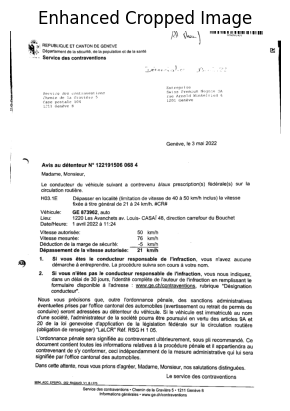

In [40]:
import cv2
import numpy as np

# Function to enhance image quality
def enhance_image(cropped_img):
    # Convert cropped image to OpenCV format (BGR)
    cropped_img_bgr = cv2.cvtColor(np.array(cropped_img), cv2.COLOR_RGB2BGR)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    
    # Ensure the grayscale image is in the correct data type (8-bit unsigned integer)
    gray = np.uint8(gray)
    
    # Apply adaptive thresholding to separate background from text
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # Invert the thresholded image
    thresholded = cv2.bitwise_not(thresholded)
    
    # Sharpen the image
    kernel = np.array([
        [-1, -1, -1],
        [-1, 12, -1],  # Increase center weight
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(thresholded, -1, kernel)
    
    return sharpened

# Assuming 'cropped_img' contains the cropped image
enhanced_cropped_img = enhance_image(cropped_img)
plt.imshow(enhanced_cropped_img, cmap='gray')
plt.title('Enhanced Cropped Image')
plt.axis('off')
plt.show()


# Check Difference 

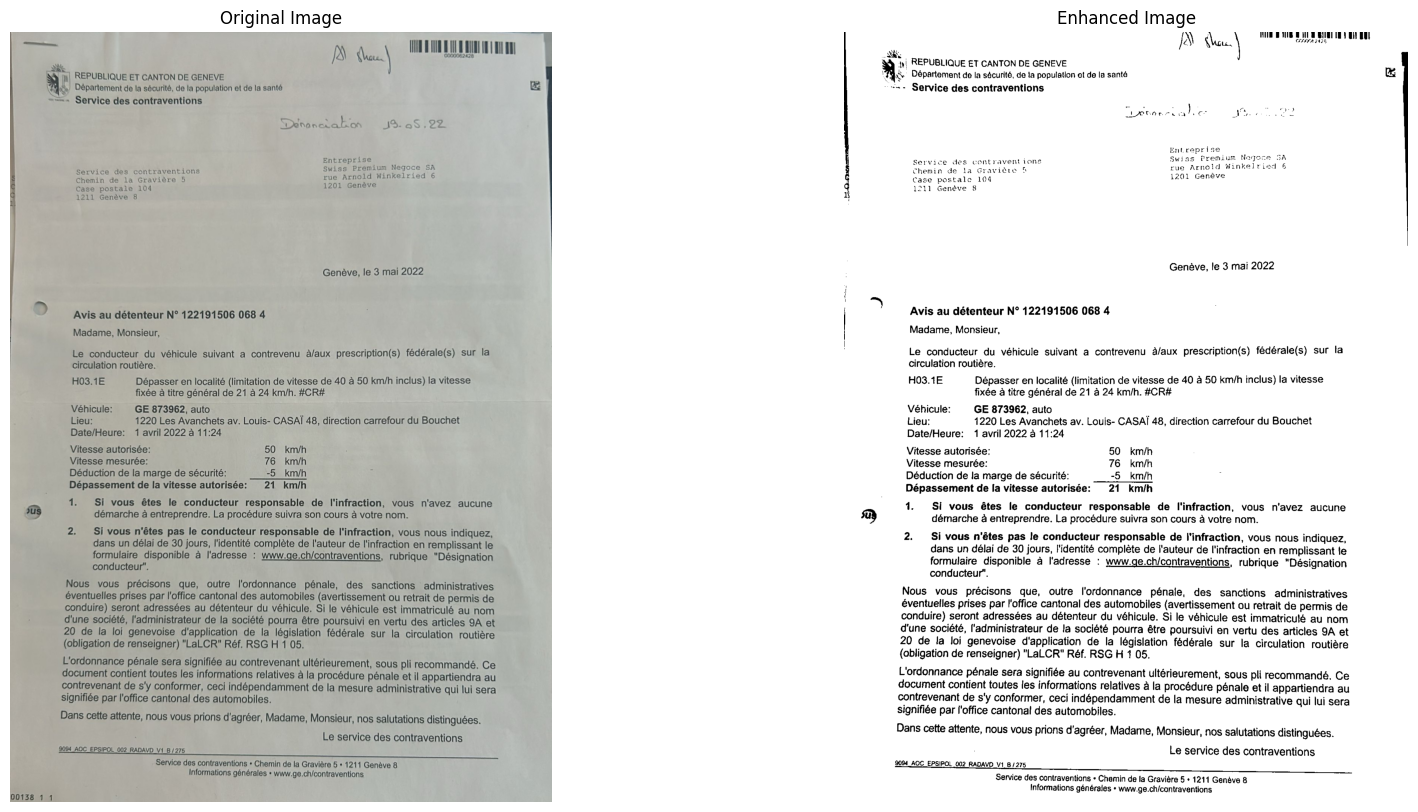

In [41]:
# Plot the original and enhanced images
plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_cropped_img, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')
plt.savefig('original_and_enhanced_images.png')
plt.show()

In [ ]:
# Define a filename for the image to be saved
output_filename = 'enhanced_image.png'
# Ensure the enhanced_upscaled_image numpy array is correctly formatted
# with pixel values in the range [0, 1] before saving.
# If the values are within [0, 255], remove the multiplication by 255.
enhanced_upscaled_image_to_save = (enhanced_upscaled_image * 255).astype(np.uint8) if enhanced_upscaled_image.max() <= 1.0 else enhanced_upscaled_image
# Save the image using OpenCV
cv2.imwrite(str(current_dir / output_filename), enhanced_upscaled_image_to_save)
print(f"Image saved as {output_filename} in the current directory")

# Extract Text 

### 1.Detect Language

#### Identifying relevant text only 

Detected language: fr


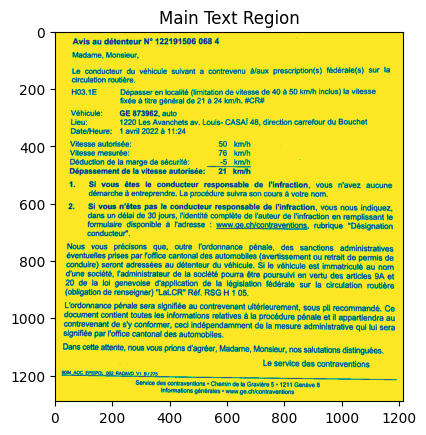

In [42]:
def detect_language(image):
    try:
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        text = pytesseract.image_to_string(image)
        language = langdetect.detect_langs(text)
        # Return the most probable language
        return language[0].lang
    except LangDetectException as e:
        print("Language detection error:", e)
        return None

# Now, determine the language of the document image
language = detect_language(enhanced_cropped_img)

if language:
    print("Detected language:", language)
    # Based on detected language, set Tesseract configuration
    if language == 'fr':
        config = '--psm 4 -l fra'
    elif language == 'de':
        config = '--psm 4 -l deu'
    elif language == 'it':
        config = '--psm 4 -l ita'
    else:
        print("Unsupported language detected.")
        config = ''
        
    # If a supported language is detected, proceed with text extraction
    if config:
        def find_densest_text_area(image, config):
            if isinstance(image, np.ndarray):
                image = Image.fromarray(image)
            
            image_np = np.array(image)
            data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
            box_map = np.zeros(image_np.shape[:2], dtype=np.uint8)

            for i in range(len(data['text'])):
                if int(data['conf'][i]) > 60:
                    x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                    box_map[y:y+h, x:x+w] += 1

            kernel_size = 50 # Increase kernel size for more aggressive merging
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            box_map_dilated = cv2.dilate(box_map, kernel, iterations=1)

            threshold_value = np.max(box_map_dilated) * 0.4  # Lower the threshold slightly
            _, box_map_thresholded = cv2.threshold(box_map_dilated, threshold_value, 255, cv2.THRESH_BINARY)

            contours, _ = cv2.findContours(box_map_thresholded.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                print("No dense text areas detected.")
                return None

            img_center_x, img_center_y = image.width // 2, image.height // 2
            max_score = 0
            best_rect = None
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                area = w * h
                center_x, center_y = x + w // 2, y + h // 2
                distance = np.sqrt((center_x - img_center_x)**2 + (center_y - img_center_y)**2)
                score = area / (distance + 1)  # Increased weight to area

                if score > max_score:
                    max_score = score
                    best_rect = (x, y, w, h)

            if not best_rect:
                print("No suitable area found.")
                return None

            x, y, w, h = best_rect
            densest_area = image.crop((x, y, x + w, y + h))

            return densest_area

        # Convert upscaled numpy array back to PIL Image
        enhanced_upscaled= Image.fromarray(enhanced_cropped_img)

        # Now, find the densest text area in the upscaled image
        relevant_text_image = find_densest_text_area(enhanced_upscaled, config)
        if relevant_text_image:
            # Display the main text region image
            plt.imshow(relevant_text_image)
            plt.title('Main Text Region')
            plt.show()
        else:
            print("No text region was extracted.")
    else:
        print("Language detection failed.")


Detected language: fr


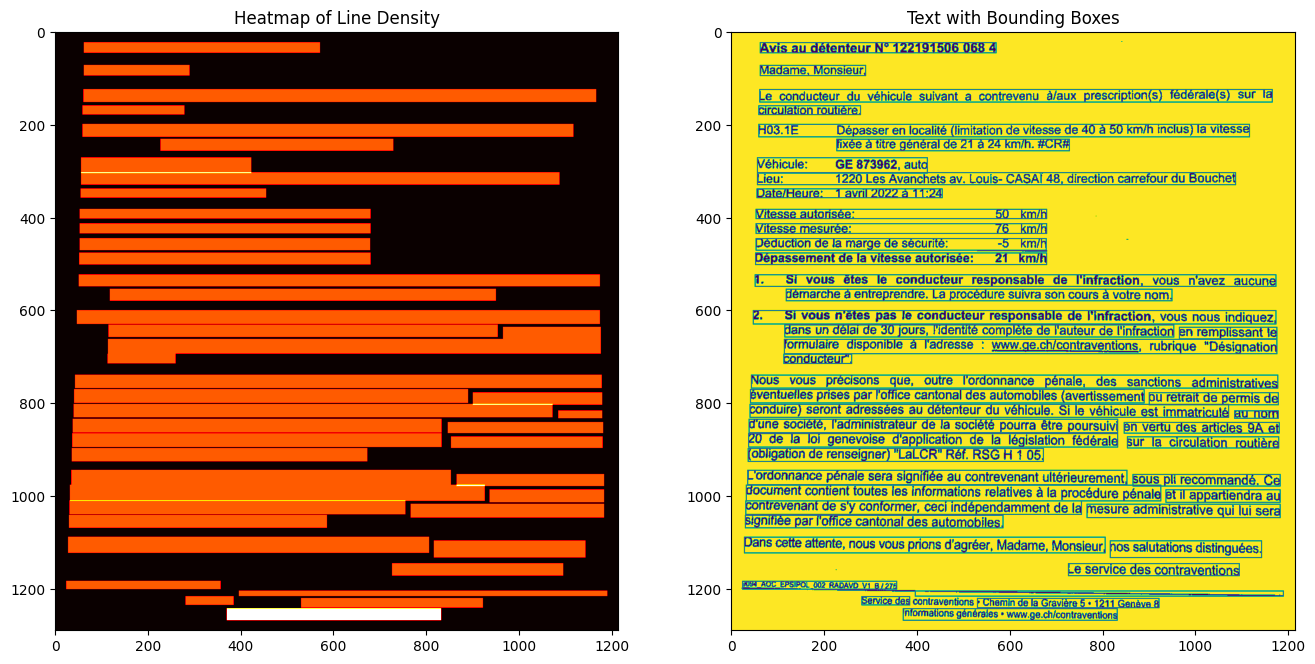

In [44]:
import numpy as np
from PIL import Image, ImageDraw
import pytesseract
import matplotlib.pyplot as plt
import langdetect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(image):
    try:
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        text = pytesseract.image_to_string(image)
        language = langdetect.detect_langs(text)
        # Return the most probable language
        return language[0].lang
    except LangDetectException as e:
        print("Language detection error:", e)
        return None

def dilate_bounding_boxes(image, config, sensitivity_factor=1):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
    words = []
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 60:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            words.append((x, y, x + w, y + h))
    
    # Merge bounding boxes into lines based on horizontal proximity
    lines = []
    current_line = words[0]
    for word in words[1:]:
        if abs(word[1] - current_line[1]) < 10 * sensitivity_factor:  # Adjust this value for vertical proximity
            current_line = (current_line[0], min(current_line[1], word[1]), word[2], max(current_line[3], word[3]))
        else:
            # Ensure valid x-coordinates
            if current_line[2] < current_line[0]:
                current_line = (current_line[2], current_line[1], current_line[0], current_line[3])
            lines.append(current_line)
            current_line = word
    lines.append(current_line)
    
    # Ensure valid x-coordinates for the last line
    if current_line[2] < current_line[0]:
        current_line = (current_line[2], current_line[1], current_line[0], current_line[3])
    lines.append(current_line)
    
    return lines

# Detect language of the document image
language = detect_language(relevant_text_image)

if language:
    print("Detected language:", language)
    # Based on detected language, set Tesseract configuration
    if language == 'fr':
        config = '--psm 4 -l fra'
    elif language == 'de':
        config = '--psm 4 -l deu'
    elif language == 'it':
        config = '--psm 4 -l ita'
    else:
        print("Unsupported language detected.")
        config = ''

# Dilate bounding boxes and group words into lines
sensitivity_factor = 1  # Adjust this value for sensitivity
lines = dilate_bounding_boxes(relevant_text_image, config, sensitivity_factor)

# Visualize a heatmap and bounding boxes
heatmap = np.zeros_like(np.array(relevant_text_image), dtype=np.float32)
for x1, y1, x2, y2 in lines:
    heatmap[y1:y2, x1:x2] += 1

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the heatmap
axs[0].imshow(heatmap, cmap='hot')
axs[0].set_title('Heatmap of Line Density')

# Visualize bounding boxes overlaid on another image
overlay_image = relevant_text_image.copy()
draw = ImageDraw.Draw(overlay_image)
for x1, y1, x2, y2 in lines:
    draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

# Plot the image with bounding boxes
axs[1].imshow(overlay_image)
axs[1].set_title('Text with Bounding Boxes')

plt.show()


In [45]:
def save_lines_as_images(image, lines, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    else:
        # Clear existing files in the output folder
        files = os.listdir(output_folder)
        for file in files:
            os.remove(os.path.join(output_folder, file))
    
    # Save lines as images
    for i, (x1, y1, x2, y2) in enumerate(lines):
        line_image = image.crop((x1, y1, x2, y2))
        line_image.save(f"{output_folder}/line_{i+1}.png")

# Output folder for saving lines as images
output_folder = "line_images"

# Save the lines as images
save_lines_as_images(relevant_text_image, lines, output_folder)


### Extracting relevant text 

In [46]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

# Initialize the OCR predictor from doctr
model = ocr_predictor(pretrained=True)

# Assuming `output_folder` contains the path to your folder with line images
line_images_paths = [os.path.join(output_folder, f"line_{i+1}.png") for i in range(len(lines))]

# Array to hold all extracted texts
extracted_texts = []

# Process each image and extract text
for img_path in line_images_paths:
    # Load the image as a document
    line_image = DocumentFile.from_images([img_path])
    
    # Analyzing the document with the model
    result = model(line_image)
    
    # Extracting text from the results
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                # Concatenating words to form lines
                line_text = ' '.join(word.value for word in line.words)
                print(line_text)
                extracted_texts.append(line_text)

Avis au détenteur No 122191506 068 4
Madame
Monsieur,
Le conducteur du véhicule suivant a contrevenu à/aux prescription(s) fédérale(s) sur la
circulation routière
HO3.1E
Dépasser en localité (limitation de vitesse de 40 à 50 km/h inclus) la vitesse
fixée à titre général de 21 à 24 km/h. #CR#
Véhicule:
GE 873962, auto
Lieu:
1220 Les Avanchets av. Louis- CASAI 48, direction carrefour du Bouchet
Date/Heure:
1 avril 2022 a 11:24
Vitesse autorisée:
50
km/h
Vitesse mesurée:
76 km/h
Déduction de la marge de sécurité:
5
km/h
Dépassement de la vitesse autorisée:
21 km/h
L.
Si vous êtes le conducteur responsable de l'infraction, vous n'avez aucune
démarche à entreprendre. La procédure suivra son cours à votre nom
2.
Si vous n'êtes pas le conducteur responsable de l'infraction, vous nous indiquez
dans un délai de 30 jours, l'identité complète de l'auteur de l'infraction
en remplissant le
formulaire disponible à l'adresse wwgechcontaentons, rubrique "Désignation
conducter ur
Nous vous précisons qu

### Coherent Paragraph 

In [47]:
# Concatenating all extracted text into a single string
Fixed_Layout = '\n'.join(extracted_texts)

print(Fixed_Layout)


Avis au détenteur No 122191506 068 4
Madame
Monsieur,
Le conducteur du véhicule suivant a contrevenu à/aux prescription(s) fédérale(s) sur la
circulation routière
HO3.1E
Dépasser en localité (limitation de vitesse de 40 à 50 km/h inclus) la vitesse
fixée à titre général de 21 à 24 km/h. #CR#
Véhicule:
GE 873962, auto
Lieu:
1220 Les Avanchets av. Louis- CASAI 48, direction carrefour du Bouchet
Date/Heure:
1 avril 2022 a 11:24
Vitesse autorisée:
50
km/h
Vitesse mesurée:
76 km/h
Déduction de la marge de sécurité:
5
km/h
Dépassement de la vitesse autorisée:
21 km/h
L.
Si vous êtes le conducteur responsable de l'infraction, vous n'avez aucune
démarche à entreprendre. La procédure suivra son cours à votre nom
2.
Si vous n'êtes pas le conducteur responsable de l'infraction, vous nous indiquez
dans un délai de 30 jours, l'identité complète de l'auteur de l'infraction
en remplissant le
formulaire disponible à l'adresse wwgechcontaentons, rubrique "Désignation
conducter ur
Nous vous précisons qu

### Evaluation

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

def read_text_file(file_path):
    """Reads text from a file."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def evaluate_text_samples(ground_truth_text, extracted_text):
    """Calculates precision, recall, and F1 score for text samples."""
    # Convert texts to sets of words for comparison
    ground_truth_set = set(ground_truth_text.split())
    extracted_set = set(extracted_text.split())

    # Calculate precision, recall, and F1 score
    precision = len(ground_truth_set.intersection(extracted_set)) / len(extracted_set)
    recall = len(ground_truth_set.intersection(extracted_set)) / len(ground_truth_set)
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# Define paths to ground truth and extracted text files
ground_truth_path = "CorrectText.txt"
extracted_text_path = "ExtractedText.txt"

# Read text from files
ground_truth_text = read_text_file(ground_truth_path)
extracted_text = read_text_file(extracted_text_path)

# Calculate precision, recall, and F1 score
precision, recall, f1 = evaluate_text_samples(ground_truth_text, extracted_text)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9226519337016574
Recall: 0.8586118251928021
F1 Score: 0.8894806924101198


# Translate from any language to English 

In [48]:
from googletrans import Translator

def translate_to_english(Fixed_Layout):
    translator = Translator()

    # Detect language
    detected_lang = translator.detect(Fixed_Layout).lang

    # Translate to English if necessary
    if detected_lang != 'en':
        translated_text = translator.translate(Fixed_Layout, dest='en').text
    else:
        translated_text = Fixed_Layout

    return translated_text

translated_text = translate_to_english(Fixed_Layout)
print("Translated Text:", translated_text)

Translated Text: Notice to holder no 122191506 068 4
Madam
Sir,
The driver of the following vehicle has contravened the federal federal prescription (s) on the
traffic
HO3.1E
Exceed in locality (speed limit of 40 to 50 km/h included) the speed
fixed generally from 21 to 24 km/h.#Cr#
Vehicle:
GE 873962, auto
Place:
1220 Avanchers BC.Louis-Casai 48, direction Carrefour du Bouchet
Date hour:
April 1, 2022 at 11:24
Authorized speed:
50
km/h
Measured speed:
76 km/h
Deduction of the safety margin:
5
km/h
Overlapping the authorized speed:
21 km/h
L.
If you are the driver responsible for the offense, you have no
approach to undertake.The procedure will take its course in your name
2.
If you are not the driver responsible for the offense, you tell us
within 30 days, the complete identity of the author of the offense
by filling the
form available at wwgechcontaentons, section "designation
Drive Ur
We point out that, in addition to the criminal order, administrative sanctions
possible taken by th

# Extreact Features (NLP)

In [49]:
import re
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

# Load BERT model and tokenizer
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Set up the question-answering pipeline
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# Assuming 'densest_text' is the context obtained from previous text processing steps
questions = [
    "What is the plate number of the car?",
    "When did the infraction happen?",
    "hour and minutes the infraction happened?",
    "What was the infraction?"
]

# Get answers from the model using the densest_text as context
answers = {question: qa_pipeline({"question": question, "context": translated_text})['answer'] for question in questions}
# Extract the date of the infraction and the details of the infraction
Plate_Number = answers["What is the plate number of the car?"]
date_of_infraction = answers["When did the infraction happen?"]
Time_of_infraction = answers["hour and minutes the infraction happened?"]
infraction_details = answers["What was the infraction?"]

# Print the cleaned output
print("Plate Number:", Plate_Number)
print("Date and time of Infraction:", date_of_infraction)
print("Time of Infraction:", Time_of_infraction)
print("Infraction Details:", infraction_details)


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Plate Number: GE 873962
Date and time of Infraction: April 1, 2022
Time of Infraction: 11:24
Infraction Details: withdrawal of permit
driving


# Fine Estimation

In [64]:
import pandas as pd
import dateparser

# Function to convert date to standard format
def convert_date_to_standard_format(date_str):
    try:
        settings = {'DATE_ORDER': 'DMY', 'PREFER_DAY_OF_MONTH': 'first'}
        
        parsed_date = dateparser.parse(date_str, settings=settings)
        formatted_date = parsed_date.strftime('%d/%m/%Y')
        return formatted_date
    except ValueError:
        return None

# Function to match extracted information with CSV file
def match_with_csv(answers):
    plate_number = answers["What is the plate number of the car?"]
    offense_date = answers["When did the infraction happen?"]
    infraction = answers["What was the infraction?"]
    
    standard_offense_date = convert_date_to_standard_format(offense_date)
    
    if standard_offense_date is None:
        return pd.DataFrame() 
    
    file_path = ("Cars_sales_data_2023.xlsx")
    df = pd.read_excel(file_path)
    
    df['Pick Up DateTime'] = pd.to_datetime(df['Pick up date'], format='%d/%m/%Y')
    df['Drop Off DateTime'] = pd.to_datetime(df['Drop off date'], format='%d/%m/%Y')
    
    matching_rows = df[(df['Plate Number'] == plate_number) &
                       (df['Pick Up DateTime'] <= standard_offense_date) &
                       (df['Drop Off DateTime'] >= standard_offense_date)]
    
    return matching_rows

# Match extracted information with the CSV file
matching_rows = match_with_csv(answers)

# Extract client name if a match is found
if not matching_rows.empty:
    client_name = matching_rows.iloc[0]['Client name']
    print("Nom du client trouvé :", client_name)
    
else:
    print("Aucun enregistrement correspondant trouvé pour les informations extraites.")


Aucun enregistrement correspondant trouvé pour les informations extraites.


In [50]:
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from FineEstimator import estimate_fine, estimate_parking_fine

# Load a pre-trained model and tokenizer for sequence classification
model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up the text classification pipeline
classification_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Translate the text if needed and obtain the translated_text variable

# Assuming 'translated_text' is the context obtained from previous text processing steps

print("Translated Text:")
print(translated_text)

# Run sentiment analysis to identify if the document contains information about speeding or parking
sentiment_result = classification_pipeline(translated_text)

print("Sentiment Analysis Result:")
print(sentiment_result)

# Check if the sentiment result is empty or not
if sentiment_result:
    # Check if the sentiment indicates a violation related to speeding or parking
    violation_type = None
    if sentiment_result[0]['label'] == 'LABEL_1':
        violation_type = 'speeding'
    elif sentiment_result[0]['label'] == 'LABEL_0':
        violation_type = 'parking'

    print("Violation Type:", violation_type)

    # Define regular expressions to match speed-related phrases
    measured_speed_pattern = re.compile(r'Speed measured: (\d+)\s+km/h')
    allowed_speed_pattern = re.compile(r'Authorized speed: (\d+)\s+km/h')

    # Extract relevant information based on the detected violation type
    if violation_type == 'speeding':
        # Search for measured speed and allowed speed in the translated text using regular expressions
        measured_speed_match = measured_speed_pattern.search(translated_text)
        allowed_speed_match = allowed_speed_pattern.search(translated_text)

        print("Measured Speed Match:", measured_speed_match)
        print("Allowed Speed Match:", allowed_speed_match)

        # Extract measured speed and allowed speed from the matches
        measured_speed = int(measured_speed_match.group(1)) if measured_speed_match else None
        allowed_speed = int(allowed_speed_match.group(1)) if allowed_speed_match else None

        print("Measured Speed:", measured_speed)
        print("Allowed Speed:", allowed_speed)

        # Estimate speeding fine using the FineEstimator.py module
        if measured_speed is not None and allowed_speed is not None:
            speeding_fine = estimate_fine(allowed_speed, measured_speed)
            # Notify the driver about the speeding violation and the estimated fine
            print(f"You were caught speeding at {measured_speed} km/h in a {allowed_speed} km/h zone.")
            print(f"Estimated fine for speeding: {speeding_fine}")
        else:
            print("Speeding information not found in the translated text.")

    elif violation_type == 'parking':
        parking_violation_type = None  # Initialize the variable
        # Check for parking violation in the translated text
        if "unlawful parking" in translated_text:
            parking_violation_type = "unlawful parking"
            print("Parking Violation Type:", parking_violation_type)
        elif "parking outside of a designated zone" in translated_text:
            parking_violation_type = "parking outside of a designated zone"
            print("Parking Violation Type:", parking_violation_type)

        if parking_violation_type:
            # Estimate parking fine using the FineEstimator.py module
            parking_fine = estimate_parking_fine(parking_violation_type)
            # Notify the driver about the parking violation and the estimated fine
            print(f"You have committed a {parking_violation_type} violation.")
            print(f"Estimated fine for parking violation: {parking_fine} CHF")
        else:
            print("Parking violation type not found.")
else:
    print("Sentiment analysis did not detect any violations in the document.")


Translated Text:
Notice to holder no 122191506 068 4
Madam
Sir,
The driver of the following vehicle has contravened the federal federal prescription (s) on the
traffic
HO3.1E
Exceed in locality (speed limit of 40 to 50 km/h included) the speed
fixed generally from 21 to 24 km/h.#Cr#
Vehicle:
GE 873962, auto
Place:
1220 Avanchers BC.Louis-Casai 48, direction Carrefour du Bouchet
Date hour:
April 1, 2022 at 11:24
Authorized speed:
50
km/h
Measured speed:
76 km/h
Deduction of the safety margin:
5
km/h
Overlapping the authorized speed:
21 km/h
L.
If you are the driver responsible for the offense, you have no
approach to undertake.The procedure will take its course in your name
2.
If you are not the driver responsible for the offense, you tell us
within 30 days, the complete identity of the author of the offense
by filling the
form available at wwgechcontaentons, section "designation
Drive Ur
We point out that, in addition to the criminal order, administrative sanctions
possible taken by th